In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data

In [2]:
path = "../data/water_dataset_reshaped.csv"
df = pd.read_csv(path)
df.head()

,Specific conductance (Maximum),"pH, standard units (Maximum)","pH, standard units (Minimum)",Specific conductance (Minimum),Specific conductance (Mean),Dissolved oxygen (Maximum),Dissolved oxygen (Mean),Dissolved oxygen (Minimum),Temperature (Mean),Temperature (Minimum),Temperature (Maximum),Target
0,0.001131,0.884615,0.001120,0.001113,0.677632,0.841463,0.765152,0.787402,0.293750,0.298077,0.276163,0.648148
1,0.001170,0.871795,0.001159,0.001152,0.703947,0.829268,0.772727,0.795276,0.293750,0.301282,0.276163,0.648148
2,0.001326,0.884615,0.001198,0.001250,0.677632,0.853659,0.750000,0.755906,0.300000,0.298077,0.287791,0.648148
3,0.014094,0.858974,0.001238,0.003926,0.697368,0.829268,0.772727,0.771654,0.296875,0.294872,0.279070,0.638889
4,0.088109,0.858974,0.010766,0.029297,0.684211,0.853659,0.765152,0.755906,0.296875,0.291667,0.281977,0.648148


# Transforming continuous values to categorical

In [3]:
categorical_df = pd.DataFrame([pd.cut(df[c], 3, duplicates='drop') for c in df.columns[:-1]]).T
categorical_df["Target"] = (df["Target"] > df["Target"].median()).astype(int)
categorical_df.head()

,Specific conductance (Maximum),"pH, standard units (Maximum)","pH, standard units (Minimum)",Specific conductance (Minimum),Specific conductance (Mean),Dissolved oxygen (Maximum),Dissolved oxygen (Mean),Dissolved oxygen (Minimum),Temperature (Mean),Temperature (Minimum),Temperature (Maximum),Target
0,"(-0.000473, 0.334]","(0.803, 1.0]","(-0.000744, 0.334]","(-0.000492, 0.334]","(0.412, 0.706]","(0.813, 0.907]","(0.689, 1.0]","(0.677, 1.0]","(0.0584, 0.373]","(0.0215, 0.348]","(0.0892, 0.393]",0
1,"(-0.000473, 0.334]","(0.803, 1.0]","(-0.000744, 0.334]","(-0.000492, 0.334]","(0.412, 0.706]","(0.813, 0.907]","(0.689, 1.0]","(0.677, 1.0]","(0.0584, 0.373]","(0.0215, 0.348]","(0.0892, 0.393]",0
2,"(-0.000473, 0.334]","(0.803, 1.0]","(-0.000744, 0.334]","(-0.000492, 0.334]","(0.412, 0.706]","(0.813, 0.907]","(0.689, 1.0]","(0.677, 1.0]","(0.0584, 0.373]","(0.0215, 0.348]","(0.0892, 0.393]",0
3,"(-0.000473, 0.334]","(0.803, 1.0]","(-0.000744, 0.334]","(-0.000492, 0.334]","(0.412, 0.706]","(0.813, 0.907]","(0.689, 1.0]","(0.677, 1.0]","(0.0584, 0.373]","(0.0215, 0.348]","(0.0892, 0.393]",0
4,"(-0.000473, 0.334]","(0.803, 1.0]","(-0.000744, 0.334]","(-0.000492, 0.334]","(0.412, 0.706]","(0.813, 0.907]","(0.689, 1.0]","(0.677, 1.0]","(0.0584, 0.373]","(0.0215, 0.348]","(0.0892, 0.393]",0


# Calculating Weight of Evidence and Information Value 

In [4]:
def get_woe_iv(df: pd.DataFrame, features: list[str] = None, target: str = None) -> dict:
    assert target != None, "Target variable must be specified!"

    result = {}

    if features is None:
        features = df.columns

    for f in features:
        if f == target:
            continue
        column = df[f]
        tab = pd.crosstab(column, df[target])
        tab[0] = tab[0] / tab[0].sum()
        tab[1] = tab[1] / tab[1].sum()
        tab["WoE"] = np.log(tab[1] / tab[0])
        tab["WoE"] = tab["WoE"].replace({np.inf: 10, -np.inf: -10})
        tab["IV"] = (tab[1] - tab[0]) * tab["WoE"]
        result[f] = tab
    
    return result

In [5]:
from IPython.display import display, HTML

woe_dict = get_woe_iv(categorical_df, target="Target")

html_matrix = """
<div style="display: flex; flex-wrap: wrap; gap: 30px;">
"""

for key in woe_dict:
    html_matrix += f"""
    <div style="width: 33%; padding: 5px; border: 1px solid white;">
        {woe_dict[key].to_html()}
    </div>
    """
    
html_matrix += """
    <div style="width: 30%; padding: 5px; border: 1px solid transparent;"></div>
</div>
"""

display(HTML(html_matrix))

Target,0,1,WoE,IV
Specific conductance (Maximum),,,,
"(-0.000473, 0.334]",0.984352,0.831734,-0.168472,0.025712
"(0.334, 0.667]",0.015648,0.124845,2.076760,0.226777
"(0.667, 1.0]",0.000000,0.043421,10.000000,0.434211
Target,0,1,WoE,IV
"pH, standard units (Maximum)",,,,
"(0.41, 0.607]",0.000152,0.000310,0.711932,0.000112
"(0.607, 0.803]",0.025522,0.003638,-1.948178,0.042635
"(0.803, 1.0]",0.974326,0.996053,0.022054,0.000479
Target,0,1,WoE,IV


# Calculating Information Value for each feature

In [6]:
def get_information_value(woe_dict: dict) -> pd.DataFrame:

    predict_dict = {
        0.02: "Not useful",
        0.1: "Weak predictive power",
        0.3: "Moderate predictive power",
        0.5: "Strong predictive power"
    }

    columns = ["Independent variable", "IV", "Predictive power"]
    result = pd.DataFrame(columns=columns)

    for idx, col in enumerate(woe_dict):
        IV = np.round(woe_dict[col]["IV"].sum(), 4)
        pred_power = ""

        for key in predict_dict:
            if IV < key:
                pred_power = predict_dict[key]
                break

        if IV > 0.5:
            pred_power = "Very strong predictive power"

        result.loc[idx] = [col, IV, pred_power]
    
    result = result.sort_values(by="IV", ascending=False).reset_index(drop=True)
    return result

In [7]:
iv_df = get_information_value(woe_dict)
iv_df

,Independent variable,IV,Predictive power
0,Dissolved oxygen (Maximum),1.5581,Very strong predictive power
1,Specific conductance (Maximum),0.6867,Very strong predictive power
2,"pH, standard units (Minimum)",0.5769,Very strong predictive power
3,Specific conductance (Minimum),0.5405,Very strong predictive power
4,"pH, standard units (Maximum)",0.0432,Weak predictive power
5,Specific conductance (Mean),0.0234,Weak predictive power
6,Temperature (Minimum),0.0118,Not useful
7,Temperature (Mean),0.0110,Not useful
8,Temperature (Maximum),0.0063,Not useful
9,Dissolved oxygen (Mean),0.0019,Not useful


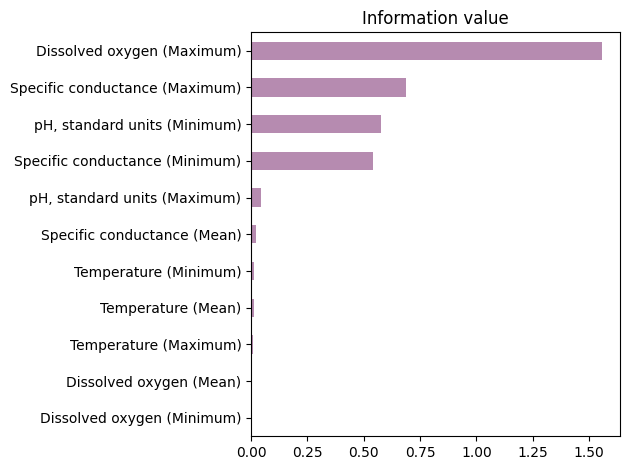

In [8]:
def random_color():
    return (np.random.random(), np.random.random(), np.random.random())

iv_df["IV"].plot(kind='barh', color=random_color())
plt.yticks(ticks=range(len(iv_df)), labels=iv_df["Independent variable"])
plt.gca().invert_yaxis()
plt.title("Information value")

plt.tight_layout()
plt.show()

# Getting highest Information Value variables

In [9]:
strongest_variables = iv_df.nlargest(4, "IV")["Independent variable"]
strongest_variables

0        Dissolved oxygen (Maximum)
1    Specific conductance (Maximum)
2      pH, standard units (Minimum)
3    Specific conductance (Minimum)
Name: Independent variable, dtype: object

# Plotting strongest variables Weight of Evidence

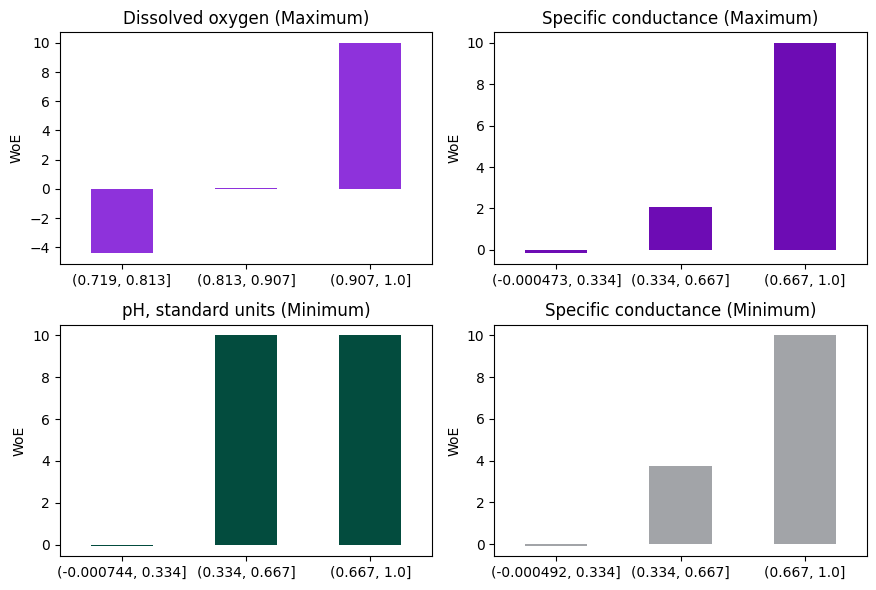

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
axes = axes.flatten()

for idx, var in enumerate(strongest_variables):
    df = woe_dict[var]
    df["WoE"].plot(kind='bar', ax=axes[idx], color=random_color())
    axes[idx].set_title(var)
    axes[idx].tick_params(axis='x', rotation=0)
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("WoE")

plt.tight_layout()
plt.show()

- analyzing WoE and IV for all feature variables, it is shown that the best variables used in predictive modeling would be Dissolved oxygen (Minimum), Specific conductance (Maximum), ph (Minimum) and Specific conductance (Minimum) since they have the best IV.

- by choosing different bin sizes for splitting continuos data into intervals, different values for WoE and IV would be obtained.

- other options for binarizing the target variable would be using the mean as the point of reference, quantile cutting or standard cutting the range into two intervals. In this example the median was used.

- using category 0 as the "success" event instead of 1 in the target variable would alter the results of IV and WoE.